# Classification of white blood cells dataset

In this jupyter notebook, we provide an example of how to extract explainable features and run a classification for the imaging flow cytometry dataset provided by:

scifAI: An explainable AI python framework for the analysis of multi-channel imaging flow cytometry data


We assume you have already installed the library. Otherwise you can install it using 

`!pip -q install <Path to the cloned module>`

This notebook provides an example for deep learning methods

here we import a series of needed modules. 

In [1]:
import scifAI
import numpy as np
from sklearn.datasets import make_classification
import torch.nn as nn
from skorch import NeuralNetClassifier
import matplotlib.pyplot as plt
import glob
from imageio import imread
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
from tqdm import tqdm
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.pipeline import Pipeline, FeatureUnion
# Compare Algorithms
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [2]:
from scifAI.dl.utils import calculate_weights, train_validation_test_split, get_statistics
from scifAI.dl.dataset import DatasetGenerator
from scifAI.dl.custom_transforms import ShuffleChannel
from scifAI.dl.models import PretrainedModel, resnet18

2023-10-30 09:10:55.173676: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-30 09:10:57.331036: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


here, we provide a function for visualizing the result of the confusion matrix which will be used later.

In [3]:
from sklearn.metrics import (matthews_corrcoef, 
                             classification_report,
                             confusion_matrix, 
                             accuracy_score, 
                             balanced_accuracy_score, 
                             cohen_kappa_score, 
                             f1_score,  
                             precision_score, recall_score)

def classification_complete_report(y_true, y_pred, plot = True ): 
    print(classification_report(y_true, y_pred))
    print(15*"----")
    print("matthews correlation coeff: %.2f" % (matthews_corrcoef(y_true, y_pred)) )
    print("Cohen Kappa score: %.2f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Accuracy: %.2f & balanced Accuracy: %.2f" % (accuracy_score(y_true, y_pred), balanced_accuracy_score(y_true, y_pred)) )
    print("macro F1 score: %.2f & micro F1 score: %.2f" % (f1_score(y_true, y_pred, average = "macro"), f1_score(y_true, y_pred, average = "micro")) )
    print("macro Precision score: %.2f & micro Precision score: %.2f" % (precision_score(y_true, y_pred, average = "macro"), precision_score(y_true, y_pred, average = "micro")) )
    print("macro Recall score: %.2f & micro Recall score: %.2f" % (recall_score(y_true, y_pred, average = "macro"), recall_score(y_true, y_pred, average = "micro")) )
    print(15*"----")
    
    

In [4]:
from joblib import Parallel, delayed
import h5py

def list_of_dict_to_dict(list_of_dicts):
    new_dict = dict()
    for one_dict in list_of_dicts:
        new_dict.update(one_dict)
    return new_dict


def get_label(h5_file_path):
    h5_file = h5py.File(h5_file_path, "r")
    ## label
    results = dict()
    try:
        results["label"] = h5_file.get("label")[()]
        results["set"] = "labeled"
    except TypeError:
        results["label"] = "-1"
        results["set"] = "unlabeled"
    try:
        results["object_number"] = os.path.split(h5_file_path)[-1]
        results["object_number"] = results["object_number"].replace(".h5", "")
        results["object_number"] = results["object_number"].split("_")[-1]
    except TypeError:
        results["object_number"] = None
    h5_file.close()
    return results

def metadata_generator(data_dir, sample_size=None, n_jobs=-1):

    metadata_columns = ["file",
                        "experiment",
                        "donor",
                        "condition",
                        "object_number",
                        "set",
                        "label"]
    metadata = pd.DataFrame(columns=metadata_columns)

    experiments_list = sorted(os.listdir(data_dir))
    print("Metadata prepration starts...")
    for exp in experiments_list:
        experiments_path = os.path.join(data_dir, exp)
        donors_list = sorted(os.listdir(experiments_path))
        for donor in donors_list:
            donors_path = os.path.join(data_dir, exp, donor)
            conditions_list = sorted(os.listdir(donors_path))
            for cond in conditions_list:
                print(exp, donor, cond)
                conditions_path = os.path.join(data_dir, exp, donor, cond + "/*.h5")
                files = glob.glob(conditions_path)

                if sample_size:
                    files = random.choices(files, k=min(sample_size, len(files)))

                metadata_temp = pd.DataFrame(columns=metadata_columns)
                metadata_temp["file"] = files
                metadata_temp["experiment"] = exp
                metadata_temp["donor"] = donor
                metadata_temp["condition"] = cond

                index_list = metadata_temp.file.tolist()

                # data parallelism
                results = Parallel(n_jobs=n_jobs)(delayed(get_label)(f) \
                            for f in tqdm(index_list, position=0, leave=True) )
                results = pd.DataFrame(results)

                if results.shape[0] > 0:
                    metadata_temp["label"] = results["label"]
                    metadata_temp["set"] = results["set"]
                    metadata_temp["object_number"] = results["object_number"]

                    metadata = pd.concat([metadata, metadata_temp], ignore_index=True)
                results = None
                metadata_temp = None
    print("...metadata prepration ended.")
    return metadata

now lets calculate the metadata:

In [5]:
%%time

data_path = "/projects/site/pred/data_science/year/2022/White_blood_cell_dataset/"
metadata = metadata_generator(data_path)

Metadata prepration starts...
Experiment_1 Donor_1 condition_1


100%|██████████| 31280/31280 [00:10<00:00, 2871.65it/s]


...metadata prepration ended.
CPU times: user 3.07 s, sys: 1.86 s, total: 4.92 s
Wall time: 12.5 s


In [6]:
row_index = metadata.label != "unknown"

metadata = metadata.loc[row_index,:].reset_index(drop = True)

lets plot a random image per class

b'CD14+ monocyte'
b'CD15+ neutrophil'
b'CD19+ B'
b'CD4+ T'
b'CD56+ NK'
b'CD8+ T'
b'NKT'
b'eosinophil'
b'unknown'


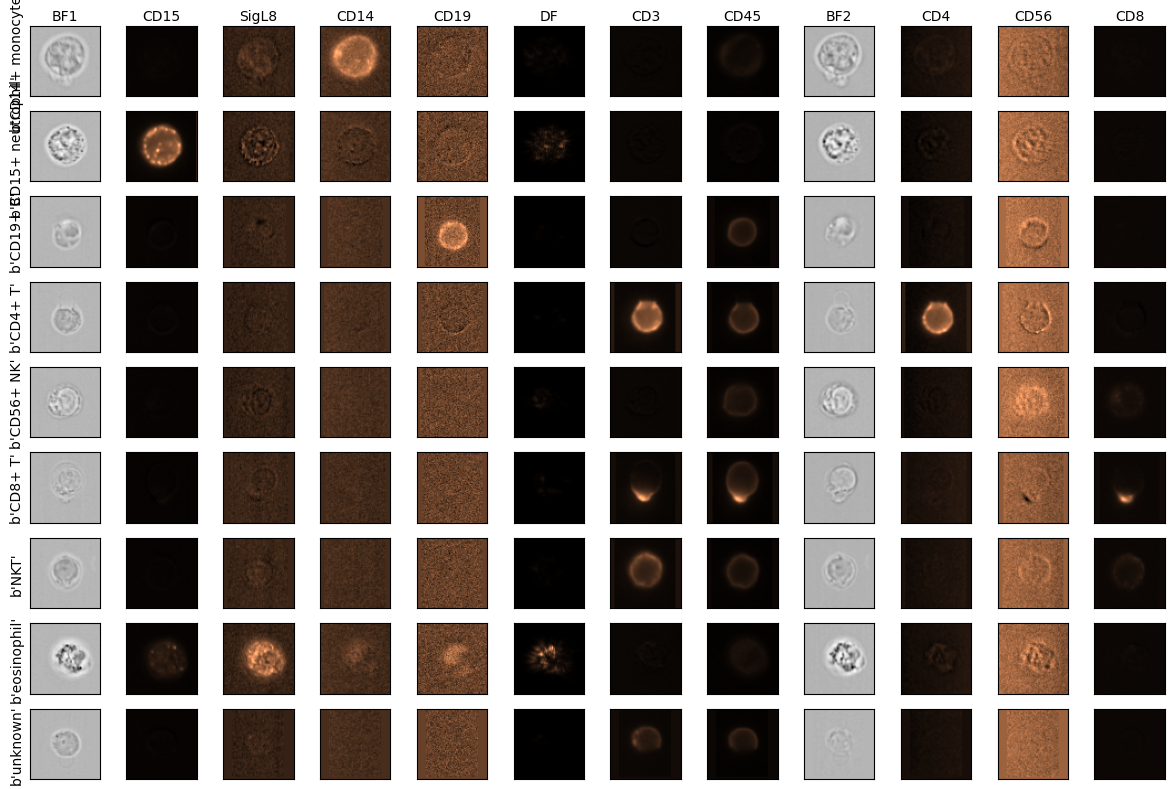

In [7]:
from skimage.util import crop
import h5py

def crop_pad_h_w(image_dummy,reshape_size):
    if image_dummy.shape[0] < reshape_size:
        h1_pad = ( reshape_size - image_dummy.shape[0])/2
        h1_pad = int(h1_pad)
        h2_pad =  reshape_size - h1_pad - image_dummy.shape[0]
        h1_crop = 0
        h2_crop = 0
    else:
        h1_pad = 0
        h2_pad = 0
        h1_crop = ( reshape_size - image_dummy.shape[0])/2
        h1_crop = abs(int(h1_crop))
        h2_crop = image_dummy.shape[0]- reshape_size  - h1_crop

    if image_dummy.shape[1] < reshape_size:
        w1_pad = (reshape_size - image_dummy.shape[1])/2
        w1_pad = int(w1_pad)
        w2_pad = reshape_size - w1_pad - image_dummy.shape[1]
        w1_crop = 0
        w2_crop = 0
    else:
        w1_pad = 0
        w2_pad = 0
        w1_crop = (reshape_size - image_dummy.shape[1])/2
        w1_crop = abs(int(w1_crop))
        w2_crop = image_dummy.shape[1]- reshape_size  - w1_crop

    h = [h1_crop, h2_crop, h1_pad, h2_pad]
    w = [w1_crop, w2_crop, w1_pad, w2_pad] 
    return h, w

def plot_images_with_metadata(metadata,  
                              figsize = None,
                              channels = ["BF","BF", "BF"],
                    channel_colors =  ["Greys", "Oranges", "Blues"],
                    image_size = 128):
    
    metadata_dummy = metadata.copy()
    metadata_dummy = metadata_dummy.reset_index(drop = True)
    
    nrows = len(metadata_dummy)
    ncols = len(channel_colors)
    
    if figsize is None:
        figsize = ( ncols*2, nrows*2 )
    fix,ax = plt.subplots(nrows, ncols, figsize = figsize, tight_layout = True)
    
    vmin = [4095.]*ncols
    vmax = [0.]*ncols
    
    for i in range(nrows):
        h5_file_ = h5py.File(metadata_dummy.loc[i,"file"], "r")
        image = h5_file_.get("image")[()]
        for j, ch in enumerate(range(ncols)):
            vmin[j] = min(vmin[j], image[:,:,ch].min()  )
            vmax[j] = max(vmax[j], image[:,:,ch].max()  )
        
    for i in range(nrows):
        h5_file_ = h5py.File(metadata_dummy.loc[i,"file"], "r")
        image = h5_file_.get("image")[()]         
        
        h, w = crop_pad_h_w(image, image_size)
        h1_crop, h2_crop, h1_pad, h2_pad =  h 
        w1_crop, w2_crop, w1_pad, w2_pad = w 
        for j, ch in enumerate(channel_colors):
            image_dummy = crop(image[:,:,j], ((h1_crop,h2_crop),(w1_crop,w2_crop)))            
            image_dummy = np.pad(image_dummy, 
                                     ((h1_pad,h2_pad),(w1_pad,w2_pad)), 
                                     'constant', 
                                     constant_values = np.mean(image_dummy) )
            ax[i,j].imshow(image_dummy, cmap = channel_colors[j] , vmin = vmin[j], vmax = vmax[j]  )
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            
            if j == 0:
                print(metadata_dummy.loc[i,"label"])
                ax[i,j].set_ylabel(metadata_dummy.loc[i,"label"])
            if i == 0:
                ax[i,j].set_xlabel(channels[j])
                ax[i,j].xaxis.set_label_position('top') 
            
        h5_file_.close()
    plt.tight_layout()

    
plot_images_with_metadata(metadata.groupby('label').apply(lambda s: s.sample(1, random_state = 2)).reset_index(drop = True) ,  
                              figsize = (12,8),
                          channels = ["BF1", "CD15","SigL8","CD14","CD19","DF","CD3", "CD45","BF2","CD4","CD56","CD8"],
                    channel_colors =  ["Greys", "copper", "copper", "copper", "copper", "copper","copper", "copper","Greys", "copper", "copper", "copper"],
                    image_size = 64)



# plt.savefig("Dataset 3 - white blood cells.png", bbox_inches='tight')
# plt.savefig("Dataset 3 - white blood cells.svg", bbox_inches='tight')

Set all random seeds to the specific value, so the results are more reproducable

Define all necessary parameters

In [8]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [9]:
class MinMaxScaler(object):
    def __init__(self, min_in , max_in, min_out, max_out):
        self.min_in = min_in.reshape(-1,1,1)
        self.max_in = max_in.reshape(-1,1,1)
        self.min_out = min_out
        self.max_out = max_out
        
    def __call__(self, tensor):
        
        tensor_ = (tensor - self.min_in)/(self.max_in - self.min_in)
        tensor_ = tensor_*(self.max_out - self.min_out) + self.min_out
        tensor_[tensor_<self.min_out]= self.min_out
        tensor_[tensor_>self.max_out]= self.max_out
        return tensor_
    
    def __repr__(self):
        return self.__class__.__name__ + '(min_out={0}, max_out={1})'.format(self.min_out, self.max_out)

In [10]:

model_dir = "models"
log_dir = "logs"
scaling_factor = 255.
reshape_size = 64
num_classes = len(metadata.label.unique())

In [11]:

selected_channels = np.arange(12)
num_channels = len(selected_channels)
channels = np.asarray(["BF1", "CD15","SigL8","CD14","CD19","DF","CD3", "CD45","BF2","CD4","CD56","CD8"])
num_of_all_channels = len(channels)
all_channels = np.arange(num_of_all_channels)

In [12]:
selected_channels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [13]:
batch_size = 128
num_workers = 4
device="cuda"

In [14]:
label_map = dict(zip(sorted(set(metadata.loc[:, "label"])), 
                     np.arange(len(set(metadata.loc[:, "label"])))))

set_of_interesting_classes = metadata.label.unique().tolist()

label_map

{b'CD14+ monocyte': 0,
 b'CD15+ neutrophil': 1,
 b'CD19+ B': 2,
 b'CD4+ T': 3,
 b'CD56+ NK': 4,
 b'CD8+ T': 5,
 b'NKT': 6,
 b'eosinophil': 7,
 b'unknown': 8}

splitting data to train, validaiton and test

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

seed_value = 42
train_index, _, _, _ = train_test_split(metadata.index, 
                                                    metadata.label.tolist(), 
                                                    stratify = metadata.label.tolist(),
                                                    test_size=0.2, 
                                                    shuffle=True,
                                                    random_state=seed_value)


skf = StratifiedKFold(n_splits=5,shuffle=False)
main_fold = 1

i = 1
for train_index, test_index in skf.split(train_index.tolist(), 
                                metadata.loc[train_index, "label"].replace(label_map)):
    if i == main_fold:
        break
    else:
        i+=1




train_index, validation_index, _, _ = train_test_split(train_index, 
                                                    metadata.loc[train_index,"label"].index.tolist(), 
                                                    stratify = metadata.loc[train_index,"label"].tolist(),
                                                    test_size=0.2, 
                                                    random_state=seed_value)

now we calculate the statistics of every channel to later use for nomalizing the dataset

In [16]:
train_dataset = DatasetGenerator(metadata=metadata.loc[train_index,:],
                                 label_map=label_map,
                                 selected_channels=selected_channels,
                                 scaling_factor=scaling_factor,
                                 reshape_size=reshape_size,
                                 transform=transforms.Compose([]))

In [17]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

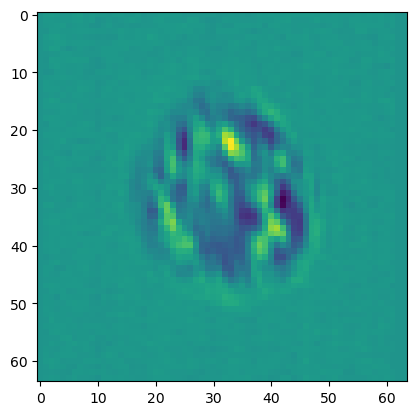

In [18]:
plt.imshow(train_dataset[0][0][0])

In [19]:
def get_statistics(dataloader, selected_channels):
    nmb_channels = len(selected_channels)

    statistics = dict()
    statistics["p01"] = torch.zeros(nmb_channels)
    statistics["p99"] = torch.zeros(nmb_channels)
    for _, data_l in enumerate(tqdm(dataloader), 0):
        image, _ = data_l
        for n in range(nmb_channels):
            statistics["p01"][n] += torch.quantile(image[:, n, :, :], 0.01)
            statistics["p99"][n] += torch.quantile(image[:, n, :, :], 0.99)

    # averaging
    for k in statistics:
        statistics[k] = statistics[k].div_(len(dataloader))

    print('statistics used: %s' % (str(statistics)))

    return statistics

In [20]:
statistics = get_statistics(train_loader, selected_channels=selected_channels)

100%|██████████| 126/126 [01:19<00:00,  1.58it/s]

statistics used: {'p01': tensor([2.4932, 0.0415, 0.2069, 0.0667, 0.1020, 0.1333, 0.1366, 0.1176, 2.4097,
        0.1722, 0.0537, 0.1201]), 'p99': tensor([3.7182, 1.8835, 0.2911, 0.1560, 0.1449, 1.6335, 1.1670, 0.6724, 3.6468,
        0.4418, 0.1316, 0.2265])}


adding the normalization to each transform

In [21]:
stats = dict()
stats["lower_bound"] = torch.tensor([statistics['p01'][0], 
                                     statistics['p01'][1], 
                                     statistics['p01'][2], 
                                     statistics['p01'][3], 
                                     statistics['p01'][4], 
                                     statistics['p01'][5], 
                                     statistics['p01'][6], 
                                     statistics['p01'][7], 
                                     statistics['p01'][8],
                                     statistics['p01'][9], 
                                     statistics['p01'][10], 
                                     statistics['p01'][11]])

stats["upper_bound"] = torch.tensor([statistics['p99'][0], 
                                     statistics['p99'][1], 
                                     statistics['p99'][2], 
                                     statistics['p99'][3], 
                                     statistics['p99'][4], 
                                     statistics['p99'][5], 
                                     statistics['p99'][6], 
                                     statistics['p99'][7], 
                                     statistics['p99'][8], 
                                     statistics['p99'][9], 
                                     statistics['p99'][10], 
                                     statistics['p99'][11]])

train_transform = [ 
        MinMaxScaler(           min_in =  stats["lower_bound"] , 
                                max_in =  stats["upper_bound"] , 
                                min_out =  0. , 
                                max_out =  1.),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        AddGaussianNoise(mean=0., std=0.01),
]

validation_transform =  [ 
        MinMaxScaler(           min_in =  stats["lower_bound"] , 
                                max_in =  stats["upper_bound"] , 
                                min_out =  0. , 
                                max_out =  1.),
]

test_transform =  [ 
        MinMaxScaler(           min_in =  stats["lower_bound"] , 
                                max_in =  stats["upper_bound"] , 
                                min_out =  0. , 
                                max_out =  1.),
]

In [22]:
train_loader = None

defining train, validation and test datasets

In [23]:
train_dataset = DatasetGenerator(metadata=metadata.loc[train_index,:],
                                 label_map=label_map,
                                 selected_channels=selected_channels,
                                 scaling_factor=scaling_factor, 
                                 reshape_size=reshape_size,
                                 transform= transforms.Compose(train_transform))

validation_dataset = DatasetGenerator(metadata=metadata.loc[validation_index,:],
                                      label_map=label_map,
                                      selected_channels=selected_channels,
                                      scaling_factor=scaling_factor,
                                      reshape_size=reshape_size,
                                      transform=transforms.Compose(test_transform))
test_dataset = DatasetGenerator(metadata=metadata.loc[test_index,:],
                                label_map=label_map,
                                selected_channels=selected_channels,
                                scaling_factor=scaling_factor,
                                reshape_size=reshape_size,
                                transform=
                                transforms.Compose(test_transform))

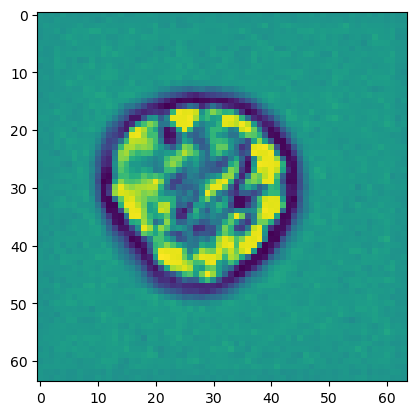

In [24]:
plt.imshow(train_dataset[5][0][0])

considering that we have multiple input channels, we need to modify the ResNet18 network input layer

In [25]:
import torch.nn as nn
import torch.nn.functional as F

model = PretrainedModel(num_channels= len(channels),
                                     num_classes = len(set_of_interesting_classes), 
                                     pretrained = True)

In [26]:
model

PretrainedModel(
  (model): ResNet(
    (conv1): Conv2d(12, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=

finally, we add a scheduler and an early stopping based on valid_f1_macro

In [27]:
model.load_state_dict(torch.load('white_blood_cells_DL_fold' + str(main_fold) +'.pth')) 

model.cuda()

PretrainedModel(
  (model): ResNet(
    (conv1): Conv2d(12, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=

we stopped the training in 5 epochs. but you can let it train for longer time! :) 

lets take a look the prediction pefromance fore the validation set

### Model Interpretation

In [28]:
# where to save results
model_name = "resnet18"
dataset_name = "synapse formation"


#### Pixel-Permutation Tests

In [29]:
from time import process_time

In [30]:

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [31]:
correct = 0.
total = 0.
y_true = list()
y_pred = list()
y_true_proba = list()
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device).float(), data[1].to(device).long()
        outputs = model(inputs)
        pred = outputs.argmax(dim=1)
        true_proba = np.array([j[i] for (i,j) in zip(pred, outputs.cpu())])
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (labels.reshape(-1) == predicted).sum().item()
        for i in range(len(pred)):
            y_true.append(labels[i].item())
            y_pred.append(pred[i].item())
            y_true_proba.append(true_proba[i].item())

In [32]:
class_names_targets = [c for c in label_map.keys()]
print(classification_report(y_true, y_pred, digits=2))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       189
           1       1.00      1.00      1.00      2943
           2       0.98      1.00      0.99       128
           3       0.99      0.99      0.99       720
           4       0.97      0.97      0.97        99
           5       0.98      0.99      0.98       297
           6       0.90      0.91      0.91       158
           7       0.99      1.00      1.00       256
           8       0.91      0.85      0.88       215

    accuracy                           0.99      5005
   macro avg       0.96      0.97      0.97      5005
weighted avg       0.99      0.99      0.99      5005



In [33]:
## k ablation

In [ ]:
%%time

t1_start = process_time()
f1_score_original = f1_score(y_true, y_pred, average=None, labels=np.arange(num_classes))
shuffle_times_list = [5,10,20,30,40,50,100,200,500,1000]
shuffle_times_results_order = dict()
shuffle_times_results_values = dict()
for shuffle_times in shuffle_times_list:
    min_mean_dif = 1.0
    candidate = 0
    df_all = pd.DataFrame([], columns=class_names_targets)
    for c in range(num_channels):
        f1_score_diff_from_original_per_channel_per_shuffle = []
        transform = test_transform.copy()
        transform.append(ShuffleChannel(channels_to_shuffle=[c]))
        for s in tqdm(range(shuffle_times)):
            dataset = DatasetGenerator(metadata=metadata.loc[test_index,:],
                                     label_map=label_map,
                                     selected_channels=selected_channels,
                                     scaling_factor=scaling_factor,
                                     reshape_size=reshape_size,
                                     transform=transforms.Compose(transform))
            dataloader = DataLoader(dataset,
                                    batch_size=batch_size,
                                    shuffle=False,
                                    num_workers=num_workers)
            y_true = list()
            y_pred = list()
            with torch.no_grad():
                for data in dataloader:
                    inputs, labels = data[0].to(device).float(), data[1].to(device).reshape(-1).long()
                    outputs = model(inputs)
                    pred = outputs.argmax(dim=1)
                    for i in range(len(pred)):
                        y_true.append(labels[i].item())
                        y_pred.append(pred[i].item())
                f1_score_per_channel = f1_score(y_true, y_pred, average=None, labels=np.arange(num_classes))
                f1_score_diff_from_original_per_channel_per_shuffle.append(f1_score_original - f1_score_per_channel)
        mean_along_columns = np.mean(f1_score_diff_from_original_per_channel_per_shuffle, axis=0)
        mean_dif = np.mean(mean_along_columns)
        if mean_dif < min_mean_dif and mean_dif > 0 and not selected_channels[c]:
            min_mean_dif = mean_dif
            candidate = selected_channels[c]
        df_diff = pd.DataFrame(np.atleast_2d(f1_score_diff_from_original_per_channel_per_shuffle), columns=class_names_targets)
        df_mean_diff = pd.DataFrame(np.atleast_2d(mean_along_columns), columns=class_names_targets)
        df_all = pd.concat([df_all, df_mean_diff], ignore_index=True, sort=False)
        shuffle_times_results_order[shuffle_times] = df_all.T.mean().argsort()
        shuffle_times_results_values[shuffle_times] = df_all.T.mean()
    
    pd.DataFrame(shuffle_times_results_order).to_csv("shuffle_times_results_order" + str(main_fold) + ".csv")
    pd.DataFrame(shuffle_times_results_values).to_csv("shuffle_times_results_values" + str(main_fold) + ".csv")

pd.DataFrame(shuffle_times_results_order).to_csv("shuffle_times_results_order" + str(main_fold) + ".csv")
pd.DataFrame(shuffle_times_results_values).to_csv("shuffle_times_results_values" + str(main_fold) + ".csv")

torch.cuda.empty_cache()

 12%|█▏        | 60/500 [02:46<20:11,  2.75s/it]

In [ ]:
pd.DataFrame(shuffle_times_results_order)

In [ ]:
pd.DataFrame(shuffle_times_results_values)